# Starter cell 
## Run this cell first to enable working with this notebook

In [1]:
# Starter cell: make repo root importable, then run bootstrap
import sys
from pathlib import Path

# If running a notebook inside scripts/, cwd is .../perch-scale-bird-weights/scripts
# -> parent() is the repo root. If your notebooks are deeper, bump parents[2], etc.
ROOT = Path.cwd()
for _ in range(5):       # walk up to 5 levels until we find the repo
    if (ROOT / ".git").exists() or (ROOT / "README.md").exists():
        break
    ROOT = ROOT.parent

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Part 1 - Core functions for plotting and computing metrics

In [19]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Repo helpers
from scripts import _paths as P
from scripts.helpers import read_timeseries, find_bird_file
from scripts.helpers import find_stable_estimates  # <- your revised function

# ---------- Small helpers ----------
def _ensure_fig_ax(ax, figsize):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure
    return fig, ax

def _ref_and_thresholds(bird_id, weights_dict, df, low_thrd, high_thrd, tol):
    # weights_dict keyed by canonical IDs (e.g., '1','2','3', 'p1','t1')
    aw = weights_dict.get(str(bird_id), [])
    aw_vals = [v for v in aw if v is not None]
    ref = np.mean(aw_vals) if len(aw_vals) else (df['weight'].mean() if not df['weight'].empty else None)
    if ref is not None:
        low_thrd, high_thrd = ref * (1 - tol), ref * (1 + tol)
    return ref, low_thrd, high_thrd, aw

def _downsample(df, raw_downsample, raw_day, raw_night):
    if raw_day is not None and raw_night is not None and not df.empty:
        df = df.copy()
        df['hour'] = df['Time'].dt.hour
        df['is_night'] = ((df['hour'] >= 20) | (df['hour'] < 6))
        return (pd.concat([
            df.loc[~df['is_night']].iloc[::max(1, int(raw_day))],
            df.loc[df['is_night']].iloc[::max(1, int(raw_night))]
        ]).sort_index())
    return df.iloc[::max(1, int(raw_downsample))]

# ---------- Panel A: longitudinal ----------
def plot_longitudinal(
    bird_id,
    weight_report_csv,
    weights_dict,
    low_thrd=1, high_thrd=30,
    win_size=10, step=10, weight_fraction=0.09,
    start_date=None, end_date=None, start_time=None, end_time=None,
    figsize=(12, 4),
    raw_downsample=5, rel_downsample=5,
    apply_ylim=False, add_actual_weights=True, ax=None,
    raw_downsample_day=None, raw_downsample_night=None,
    tolerance_fraction=0.3,
    keep_out_of_range=True,
):
    df0 = read_timeseries(
        file_path=weight_report_csv,
        low_thrd=low_thrd, high_thrd=high_thrd,
        start_date=start_date, end_date=end_date,
        start_time=start_time, end_time=end_time,
        keep_out_of_range=keep_out_of_range
    )
    if df0.empty:
        print(f"No data after filtering for {bird_id}."); return None, None

    ref, lo, hi, actual_weights = _ref_and_thresholds(str(bird_id), weights_dict, df0, low_thrd, high_thrd, tolerance_fraction)
    mask = (df0['weight'] >= lo) & (df0['weight'] <= hi)
    if not mask.any():
        print(f"No data within thresholds for {bird_id} (ref: {ref}, lo: {lo}, hi: {hi})."); return None, None

    df = df0.assign(weight=df0['weight'].where(df0['weight'].between(lo, hi)))
    df['date'] = df['Time'].dt.date.astype(str)

    # Stable estimates (revised function)
    rel = find_stable_estimates(
        df, win_size=win_size, step=step,
        weight_fraction=weight_fraction, reference_weight=ref
    )
    rel = rel if (rel is not None and len(rel)) else pd.DataFrame(columns=['Time','weight'])
    if not rel.empty:
        rel['date'] = pd.to_datetime(rel['Time']).dt.date.astype(str)

    fig, ax = _ensure_fig_ax(ax, figsize)
    df_plot = _downsample(df0, raw_downsample, raw_downsample_day, raw_downsample_night)
    if len(df_plot):
        ax.scatter(df_plot['Time'], df_plot['weight'], s=7, alpha=0.3, color='blue', label='Raw')

    if len(rel):
        rel_plot = rel.iloc[::max(1, int(rel_downsample))]
        ax.scatter(pd.to_datetime(rel_plot['Time']), rel_plot['weight'], s=5, color='orange', label='Stable', zorder=3)

    for day in sorted(df['date'].unique()):
        ax.axvline(pd.to_datetime(day), color='k', linestyle='--', alpha=0.2, zorder=0)

    if add_actual_weights and isinstance(actual_weights, (list, tuple)) and len(actual_weights):
        days = sorted(df['date'].unique())
        for i, day in enumerate(days):
            if i >= len(actual_weights) or actual_weights[i] is None: continue
            day_center = pd.to_datetime(day) + pd.Timedelta(hours=12)
            val = actual_weights[i]
            ax.plot(day_center, val, marker='_', color='red', markersize=30, markeredgewidth=4, label='Actual' if i==0 else "", zorder=4)
            ax.plot(day_center, val*(1+tolerance_fraction), marker='_', color='black', markersize=15, markeredgewidth=2, label=f'±{int(100*tolerance_fraction)}%' if i==0 else "", zorder=5)
            ax.plot(day_center, val*(1-tolerance_fraction), marker='_', color='black', markersize=15, markeredgewidth=2, zorder=5)

    days = sorted(df['date'].unique())
    ax.set_xticks([pd.to_datetime(d) for d in days]); ax.set_xticklabels(np.arange(len(days)), ha='right')
    if not df['Time'].empty:
        ax.set_xlim(df['Time'].min() - pd.Timedelta(hours=4), df['Time'].max() + pd.Timedelta(hours=4))
    if apply_ylim and (not rel.empty) and ('weight' in rel):
        ax.set_ylim(rel['weight'].min() * 0.55, rel['weight'].max() * 1.45)
    else:
        ax.set_ylim(0, df0['weight'].max())

    ax.set_xlabel('Time (Days)'); ax.set_ylabel('Weight (g)'); ax.set_title(f'Bird {bird_id}: longitudinal')
    ax.legend(loc='best')
    plt.tight_layout()
    return fig, ax

# ---------- Daily mode from all data (used in summary) ----------
def calc_mode_per_day(df, actual_weight=None, tolerance_fraction=0.3):
    # Returns dict: date -> mode(weight) within [ref*(1±tol)], else np.nan
    out = {}
    if df.empty:
        return out
    ref = actual_weight if actual_weight is not None else df['weight'].median()
    low, high = ref*(1 - tolerance_fraction), ref*(1 + tolerance_fraction)

    df_day = df[(df['weight'] >= low) & (df['weight'] <= high)].copy()
    if df_day.empty:
        return {d: np.nan for d in pd.to_datetime(df['Time']).dt.date.astype(str).unique()}

    df_day['date'] = pd.to_datetime(df_day['Time']).dt.date.astype(str)
    for d, g in df_day.groupby('date'):
        m = g['weight'].mode()
        out[d] = float(m.iloc[0]) if not m.empty else np.nan
    return out

# ---------- Panel B: summary (compute) ----------
def compute_stable_weight_summary(
    bird_id,
    weight_report_csv,
    weights_dict,
    low_thrd=1, high_thrd=30,
    win_size=10, step=10, weight_fraction=0.09,
    start_date=None, end_date=None, start_time=None, end_time=None,
    tolerance_fraction=0.3,
    weights_csv_path="daily_manual_weights.csv",
    keep_out_of_range=False,
) -> pd.DataFrame:
    df0 = read_timeseries(
        file_path=weight_report_csv,
        low_thrd=low_thrd, high_thrd=high_thrd,
        start_date=start_date, end_date=end_date,
        start_time=start_time, end_time=end_time,
        keep_out_of_range=keep_out_of_range
    )
    if df0.empty:
        print(f"No data after filtering for {bird_id}.")
        return pd.DataFrame(columns=['date','stable_median','stable_mode','stable_mean','stable_std','stable_count','mode_estimate','true_weight','bird_id'])

    all_dates_orig = pd.to_datetime(df0['Time']).dt.date.astype(str).unique()

    ref, lo, hi, _ = _ref_and_thresholds(str(bird_id), weights_dict, df0, low_thrd, high_thrd, tolerance_fraction)
    df = df0[(df0['weight'] >= lo) & (df0['weight'] <= hi)].copy()

    rel = find_stable_estimates(
        df, win_size=win_size, step=step,
        weight_fraction=weight_fraction, reference_weight=ref
    )
    if rel is None or len(rel)==0:
        print("No stable windows found.")
        return pd.DataFrame(columns=['date','stable_median','stable_mode','stable_mean','stable_std','stable_count','mode_estimate','true_weight','bird_id'])

    rel['date'] = pd.to_datetime(rel['Time']).dt.date.astype(str)
    g = rel.groupby('date')['weight']
    summary = g.agg(
        stable_median='median',
        stable_mean='mean',
        stable_std='std',
        stable_count='size'
    ).reset_index()

    # Daily stable mode
    stable_mode = g.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index(name='stable_mode')
    summary = summary.merge(stable_mode, on='date', how='left')

    # Mode estimate from all data per day
    mode_map = calc_mode_per_day(df, actual_weight=ref, tolerance_fraction=tolerance_fraction)
    summary['mode_estimate'] = summary['date'].map(mode_map)

    # Optional: true weights (from a wide CSV indexed by bird_id)
    summary['true_weight'] = np.nan
    try:
        wdf = pd.read_csv(weights_csv_path)  # don't force index
        if 'bird_id' not in wdf.columns:
            raise ValueError("CSV must contain a 'bird_id' column")

        # Match the dtype of bird_id to the CSV
        if pd.api.types.is_numeric_dtype(wdf['bird_id']):
            bid = pd.to_numeric(bird_id, errors='coerce')
        else:
            wdf['bird_id'] = wdf['bird_id'].astype(str).str.strip()
            bid = str(bird_id).strip()

        wdf = wdf.set_index('bird_id')

        if bid in wdf.index:
            row = wdf.loc[bid]  # Series with columns like '2025-06-11', ...
            # Map summary dates to that row; non-existing dates become NaN
            summary['true_weight'] = pd.to_numeric(summary['date'].map(row), errors='coerce')
        else:
            print(f"bird_id {bird_id!r} not found in '{weights_csv_path}'")

    except Exception as e:
        print(f"Couldn't load true weights from '{weights_csv_path}': {e}")

    summary['bird_id'] = str(bird_id)

    # Add missing dates
    all_dates = pd.Series(all_dates_orig, name='date')
    summary = all_dates.to_frame().merge(summary, on='date', how='left').sort_values('date').reset_index(drop=True)
    summary['stable_count'] = summary['stable_count'].fillna(0).astype(int)

    return summary[['date','stable_median','stable_mode','stable_mean','stable_std','stable_count','mode_estimate','true_weight','bird_id']]

# ---------- Panel B: summary (plot) ----------
def plot_stable_weight_summary(
    summary: pd.DataFrame,
    bird_id: str,
    main_estimator='mean',
    plot_mode=True, plot_mean=True, plot_median=True,
    plot_actual_weights=False,
    ax=None, figsize=(12, 4),
    drop_last=False,
):
    if summary is None or summary.empty:
        print("Empty summary; nothing to plot."); return None, None

    fig, ax1 = _ensure_fig_ax(ax, figsize)
    s = summary.iloc[:-1] if drop_last and len(summary) > 1 else summary

    est_key = {'mean':'stable_mean','median':'stable_median','mode':'stable_mode'}.get(main_estimator, 'stable_mean')
    x = np.arange(len(s))
    bw = 0.2

    ax1.bar(x, s[est_key], yerr=s['stable_std'], width=bw, alpha=1, label=f'{main_estimator.capitalize()} (bar)', color='orange', capsize=4)

    off = 0
    colors = {'stable_mean':'tab:green','stable_median':'tab:blue','stable_mode':'tab:purple'}
    if plot_mean and est_key!='stable_mean':
        off += 1; ax1.bar(x+off*bw, s['stable_mean'], yerr=s['stable_std'], width=bw, alpha=0.6, label='Mean', color=colors['stable_mean'], capsize=4)
    if plot_median and est_key!='stable_median':
        off += 1; ax1.bar(x+off*bw, s['stable_median'], yerr=s['stable_std'], width=bw, alpha=0.6, label='Median', color=colors['stable_median'], capsize=4)
    if plot_mode and est_key!='stable_mode':
        off += 1; ax1.bar(x+off*bw, s['stable_mode'], yerr=s['stable_std'], width=bw, alpha=0.6, label='Mode', color=colors['stable_mode'], capsize=4)
        if 'mode_estimate' in s: ax1.plot(x, s['mode_estimate'], 'ko', ms=5, label='Mode estimate')

    ax1.set_xticks(x + (bw*off/2 if off else 0)); ax1.set_xticklabels(s['date'], rotation=45)
    ax1.set_xlabel('Date'); ax1.set_ylabel('Weight (g)'); ax1.set_title(f'Bird {bird_id}: stable weights')

    ax2 = ax1.twinx(); ax2.plot(x, s['stable_count'], 's--', color='tab:red', label='Count'); ax2.set_ylabel('Count')
    if plot_actual_weights and s['true_weight'].notna().any():
        ax1.plot(x, s['true_weight'], 'r*', ms=8, label='True weight')

    lines, labels = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
    if lines or lines2: ax1.legend(lines+lines2, labels+labels2, loc='upper left')
    plt.tight_layout()
    return fig, ax1



# Part 2 - Generate Figure 5 panels A+B for a given bird

### The bird that is shown in **Panels A+B** is bird **'1'**

### The bird shown in **Panels D+E** is bird **'1p'**

**Panel C** (Shown in later code cell) - shows 24-hours of bird 1, from '2025-06-14 20:00' to '2025-06-14 20:00'

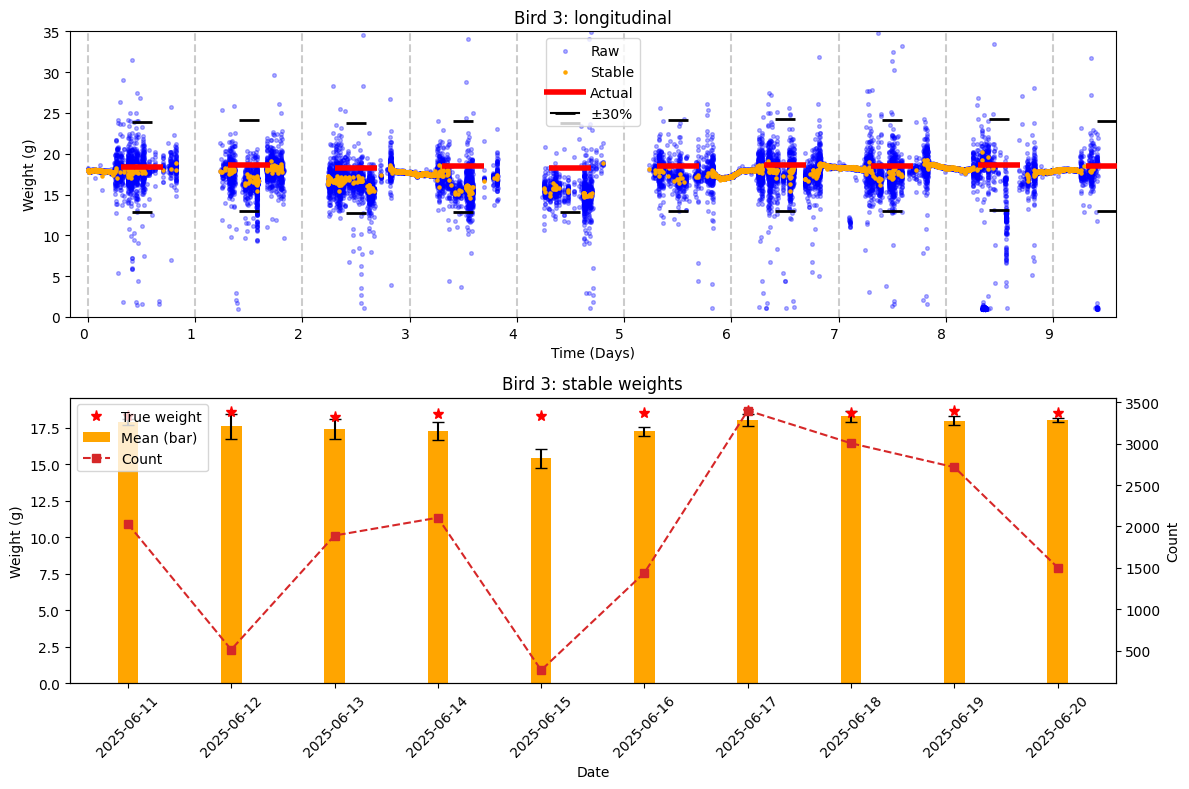

In [22]:
# Inputs
bird_id = "3"  # canonical ID ('1'..'6', 'p1', 't1', etc.)
low_thrd, high_thrd = 1, 35
win_size, step = 10, 10
weight_fraction = 0.09
tolerance_fraction = 0.3
start_date, end_date, start_time, end_time = '2025-06-11', None, None, None
raw_downsample, raw_downsample_day, raw_downsample_night = 1, 2, 40
rel_downsample = 5
keep_out_of_range = True

# Load per-bird file and manual weights dict
weights_json = P.META / "daily_manual_weights.json"         # daily manual weights per bird_id (list aligned by day)
weights_csv_path = P.META / "daily_manual_weights.csv"      # optional wide CSV of true weights
# weights_dict = {}
# read weights_csv_path dataframe and put into the dictionary:

with open(weights_json, 'r') as f:
    weights_dict = json.load(f)

weight_report_csv = find_bird_file(bird_id, birds_dir=P.BIRDS)

# Make a joint figure with two rows
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Panel A
plot_longitudinal(
    bird_id, weight_report_csv, weights_dict,
    low_thrd=low_thrd, high_thrd=high_thrd,
    win_size=win_size, step=step, weight_fraction=weight_fraction,
    start_date=start_date, end_date=end_date, start_time=start_time, end_time=end_time,
    figsize=(12,4),
    raw_downsample=raw_downsample, rel_downsample=rel_downsample,
    apply_ylim=False, add_actual_weights=True, ax=ax1,
    raw_downsample_day=raw_downsample_day, raw_downsample_night=raw_downsample_night,
    tolerance_fraction=tolerance_fraction,
    keep_out_of_range=keep_out_of_range
)

# Panel B
summary = compute_stable_weight_summary(
    bird_id, weight_report_csv, weights_dict,
    low_thrd=low_thrd, high_thrd=high_thrd,
    win_size=win_size, step=step, weight_fraction=weight_fraction,
    start_date=start_date, end_date=end_date, start_time=start_time, end_time=end_time,
    tolerance_fraction=tolerance_fraction, weights_csv_path=str(weights_csv_path),
    keep_out_of_range=keep_out_of_range
)
plot_stable_weight_summary(
    summary, bird_id,
    main_estimator='mean', plot_mode=False, plot_mean=False, plot_median=False,
    plot_actual_weights=True, ax=ax2, figsize=(12,4)
)

plt.tight_layout()
plt.show()


# Part 3 - generate Figure 5 - Panel C

### Taken from bird 1, in the time frame of: '2025-06-14 20:00' to '2025-06-15 20:00'

Filtered timeseries shape: (42469, 2)
Start weight: 19.30 g, Minimum weight: 18.51 g, End weight: 19.39 g
Number of stable windows: 4064
Manual weight for bird_id=1 on 2025-06-14: 18.13 g


/Users/cohenlab/Documents/perch-scale_manuscript_v2/scripts/helpers.py:168: UserWarning: reference_weight not provided; falling back to mode-based estimate. Provide the manual weight for canonical behavior.
  ref_w = float(mode_weight.mean())


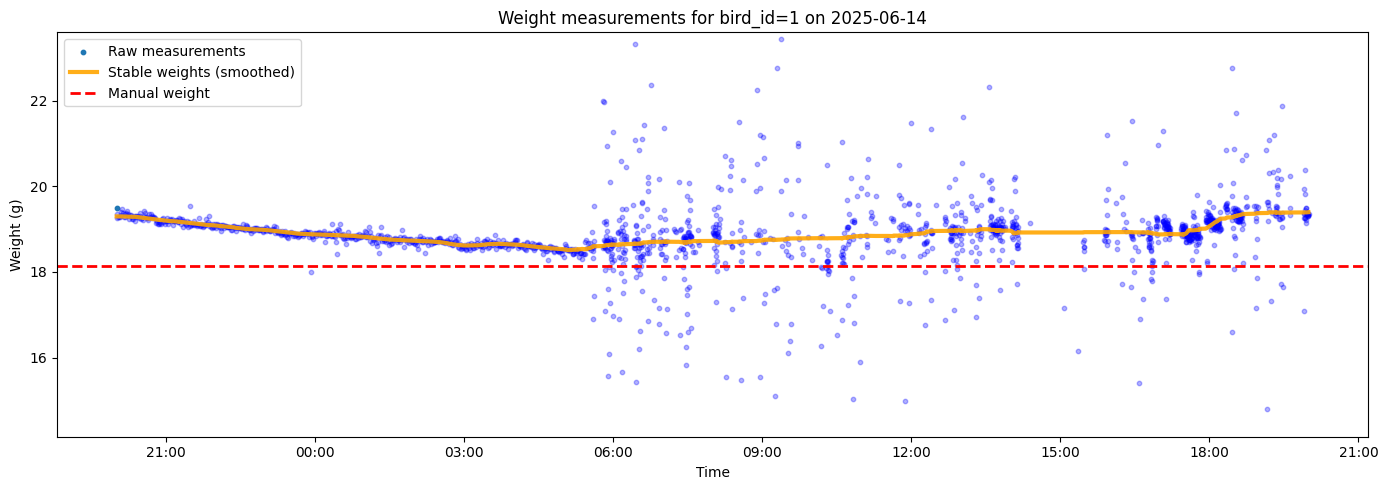

In [ ]:
# Panel C — One-day fluctuations with stable weights 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scripts import _paths as P
from scripts.helpers import read_timeseries, find_bird_file, find_stable_estimates

# --- User adjustable parameters ---
bird_id   = '1'   
start_date = '2025-06-14 20:00'
end_date   = '2025-06-15 20:00'
low_thrd  = 1
high_thrd = 50
win_size  = 10
step      = 10           
weight_fraction = 0.09
raw_downsample  = 12
rel_downsample  = 10
figsize = (14, 5)
# --- End user parameters ---

# Resolve the per-bird CSV via the new structure
try:
    weight_report_csv = find_bird_file(bird_id, birds_dir=P.BIRDS)
except FileNotFoundError as e:
    print(e)
    # Early safe return (Jupyter-friendly)
    raise SystemExit

# Read timeseries for the chosen day 
df = read_timeseries(
    file_path=weight_report_csv,
    low_thrd=low_thrd,
    high_thrd=high_thrd,
    start_date=start_date,
    end_date=end_date,
)

if df.empty:
    print(f"No data found for bird_id={bird_id} in the requested interval "
          f"[{start_date} → {end_date}] after thresholding.")
    # Early safe return (Jupyter-friendly)
    raise SystemExit

print("Filtered timeseries shape:", df.shape)

# Compute stable estimates with the new helper
rel = find_stable_estimates(
    df[df['weight'] > 1],           
    win_size=win_size,
    step=step,
    weight_fraction=weight_fraction,
    reference_weight=None            # optionally pass manual weight if you want stricter thresholding
)

# --- Manual weight lookup (new metadata & ID-based) ---
manual_weight = np.nan
try:
    wdf = pd.read_csv(P.META / "daily_manual_weights.csv")
    if 'bird_id' not in wdf.columns:
        raise ValueError("daily_manual_weights.csv must contain a 'bird_id' column.")
    # Index by bird_id (store as string to be robust to CSV typing)
    wdf['bird_id'] = wdf['bird_id'].astype(str).str.strip()
    wdf = wdf.set_index('bird_id')

    date_str = pd.to_datetime(start_date).date().isoformat()
    if (str(bird_id) in wdf.index) and (date_str in wdf.columns):
        manual_weight = pd.to_numeric(wdf.loc[str(bird_id), date_str], errors='coerce')
    else:
        print(f"(Info) Manual weight not found for bird_id={bird_id}, date={date_str}. "
              f"Check metadata columns and IDs.")
except Exception as e:
    print(f"(Info) Could not read manual weights: {e}")

# --- Plot ---
plt.figure(figsize=figsize)

# Downsample raw measurements for plotting efficiency
df_plot = df.iloc[::raw_downsample]

# Plot raw measurements (blue dots)
if len(df_plot) > 1:
    plt.scatter(df_plot.iloc[1]['Time'], df_plot.iloc[1]['weight'],
                alpha=1, label='Raw measurements', s=10)
# First part: extra downsample inside this range to reduce file size while maintaining trend
plt.scatter(df_plot['Time'][:2400:4], df_plot['weight'][:2400:4], color='blue', alpha=0.3, s=10)
# Second part: standard downsample
plt.scatter(df_plot['Time'][2400:], df_plot['weight'][2400:], color='blue', alpha=0.3, s=10)

# Smooth and plot stable estimates (orange line)
smooth_win = 200
if not rel.empty:
    rel = rel.sort_values('Time', kind='mergesort') 
    rel['weight_smooth'] = rel['weight'].rolling(window=smooth_win, center=True, min_periods=1).mean()

    start_weight   = float(rel['weight_smooth'].iloc[0]) if not rel['weight_smooth'].empty else None
    minimum_weight = float(rel['weight_smooth'].min())    if not rel['weight_smooth'].empty else None
    end_weight     = float(rel['weight_smooth'].iloc[-1]) if not rel['weight_smooth'].empty else None

    plt.plot(pd.to_datetime(rel['Time']), rel['weight_smooth'],
             linewidth=3, alpha=0.9, color='orange', label='Stable weights (smoothed)')

    if start_weight is not None and minimum_weight is not None and end_weight is not None:
        print(f"Start weight: {start_weight:.2f} g, "
              f"Minimum weight: {minimum_weight:.2f} g, "
              f"End weight: {end_weight:.2f} g")

print(f"Number of stable windows: {len(rel)}")

# Manual weight reference (dashed line)
if pd.notna(manual_weight):
    plt.axhline(manual_weight, linestyle='--', linewidth=2, color='red', label='Manual weight')
    print(f"Manual weight for bird_id={bird_id} on {pd.to_datetime(start_date).date()}: "
          f"{manual_weight:.2f} g")

# Formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# y-limits around mean stable (fallback to raw mean if no stable windows)
if not rel.empty:
    m = rel['weight'].mean()
    plt.ylim(m * 0.75, m * 1.25)
else:
    m = df['weight'].mean()
    plt.ylim(m * 0.8, m * 1.2)

plt.xlabel('Time')
plt.ylabel('Weight (g)')
plt.title(f'Weight measurements for bird_id={bird_id} on {pd.to_datetime(start_date).date()}')
plt.legend()
plt.tight_layout()


# Part 4 - generate summary table of all birds with longitudinal metrics

In [21]:
# Build a table across all birds and write to metadata/all_bird_summary.csv
weights_csv_path = P.META / "daily_manual_weights.csv"      # optional wide CSV of true weights

with open(P.META / "daily_manual_weights.json", 'r') as f:
    weights_dict = json.load(f)
rows = []
for bird_id in weights_dict.keys():
    if bird_id == 'start_date':
        continue
    try:
        fp = find_bird_file(bird_id, birds_dir=P.BIRDS)
    except FileNotFoundError:
        print(f"Skip {bird_id}: file not found.")
        continue

    s = compute_stable_weight_summary(
        bird_id, fp, weights_dict,
        low_thrd=1, high_thrd=35,
        win_size=10, step=10, weight_fraction=0.09,
        start_date='2025-06-11', end_date=None,
        tolerance_fraction=0.3, weights_csv_path=str(weights_csv_path),
        keep_out_of_range=True
    )
    if s is not None and not s.empty:
        rows.append(s)

all_summary = pd.concat(rows, axis=0, ignore_index=True) if rows else pd.DataFrame(
    columns=['date','stable_median','stable_mode','stable_mean','stable_std','stable_count','mode_estimate','true_weight','bird_id']
)

out_csv = P.META / "all_bird_summary.csv"
# out_csv.parent.mkdir(parents=True, exist_ok=True)
# all_summary.to_csv(out_csv, index=False)
all_summary.head()


,date,stable_median,stable_mode,stable_mean,stable_std,stable_count,mode_estimate,true_weight,bird_id
0,2025-06-11,18.863,19.192,18.750039,0.365562,51,18.93,18.50,2
1,2025-06-12,16.532,14.904,16.669068,0.814834,44,16.30,18.99,2
2,2025-06-13,15.273,15.080,15.942963,1.253156,109,17.18,18.66,2
3,2025-06-14,17.270,17.195,17.280922,0.259846,1465,17.27,18.49,2
4,2025-06-15,16.928,16.831,16.926757,0.274718,1859,16.89,19.00,2
